In [190]:
# %load_ext autoreload
# %autoreload 2

import os
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from IPython.display import Audio
from numpy.fft import fft, ifft
import librosa
import librosa.display
from matplotlib.pyplot import figure

%matplotlib inline

import train
from utils import load_json

#### Функции

In [191]:
# Из аудио в спектрограмму с выводом графика
def get_mel_log_spectogram(audata, sr, n_fft=500, show_plot=True):
    # Строим спектрограмму
    spec = librosa.stft(audata, n_fft=n_fft)
    # Переводим в mel - шкалу
    melspec = librosa.hz_to_mel(spec)
    # Переводим в dB - шкалу
    melspeclog = librosa.power_to_db(melspec)

    print(f'Shape: {melspeclog.shape}')
    
    plt.figure(figsize=(14, 5))
    librosa.display.specshow(melspeclog, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar();
    
    return melspeclog

In [192]:
# Из спектрограммы в аудио с помощью Griffin-Lim
def get_audata_from_mel_log_spectogram(mellogspec):
    # Убираем степень
    restored_melspec = librosa.db_to_power(mellogspec)
    # Переводим из mel в hz
    restored_spec = librosa.mel_to_hz(restored_melspec)
    # Из спектрограммы в массив
    restored_audata = librosa.griffinlim(restored_spec)
    return restored_audata

In [193]:
# Убираем паузы между словами
def remove_pauses(audata):
    return np.hstack([audata[start_i: finish_i]
                     for start_i, finish_i in librosa.effects.split(audata)])  

In [194]:
# Меняем размерность спектограммы, делим ее на части длинной L
def get_new_spectogram_shape(audata, L):
    assert L % 2 == 0, f'L must be devided by 2! {L} not devided by 2!'
    old_shape = audata.shape
    if old_shape[1] % L == 0:
        audata = audata.reshape((old_shape[1] // L, old_shape[0], L, 1))
    else:
        new_2shape = (old_shape[0], ((old_shape[1] // L) + 1) * L)
        tail = np.ones((old_shape[0], new_2shape[1] - old_shape[1])) * audata[:, old_shape[1] - 1].min()
        audata = np.hstack([audata, tail])
        audata = audata.reshape((new_2shape[1] // L, new_2shape[0], L, 1))
    return old_shape, audata

In [195]:
# Восстанавливаем обратно размерность спектограммы к исходному значению
def get_old_spectogram_shape(audata, old_shape):
    audata = audata.reshape((old_shape[0], -1))
    audata = audata[:, :old_shape[1]]
    return audata

#### Загружаем аудио

In [196]:
sandbox_dir = r'./'
assert os.path.exists(sandbox_dir)
audata_digits_row, sr_digits = librosa.load(os.path.join(sandbox_dir, 'audio/Sound_05987.mp3'))
audata_men_row, sr_men = librosa.load(os.path.join(sandbox_dir, 'audio/Sound_02503.wav'))

/Users/nikita/Documents/programs/Python/venv/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/nikita/Documents/programs/Python/venv/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


#### Очистка дорожки от пауз между словами (тишины)

In [44]:
audata_digits = remove_pauses(audata_digits_row)

In [45]:
audata_men = remove_pauses(audata_men_row)

#### Выводим аудиодорожку

In [10]:
Audio(audata_digits, rate=sr_digits)

In [11]:
Audio(audata_men, rate=sr_men)

#### Выводим график аудиоволны

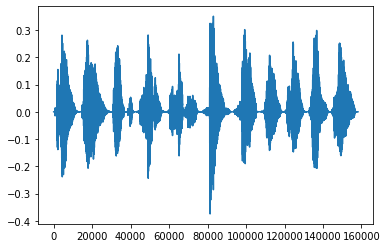

In [12]:
plt.figure()
plt.plot(audata_digits);

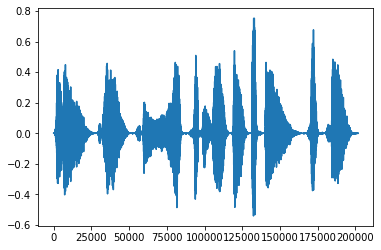

In [13]:
plt.figure()
plt.plot(audata_men);

#### В Mel Log Spectrogram

n_fft=255 -> H=128  
n_fft=510 -> H=256 - good  
n_fft=122 -> H=512  

Shape: (256, 1246)


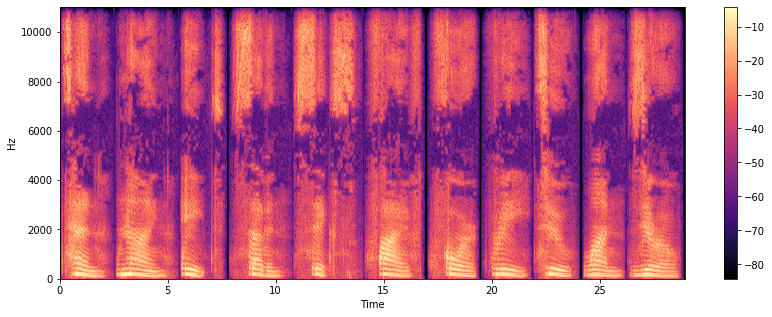

In [32]:
mellog_digits = get_mel_log_spectogram(audata_digits, n_fft=510, sr=sr_digits)

Shape: (256, 1589)


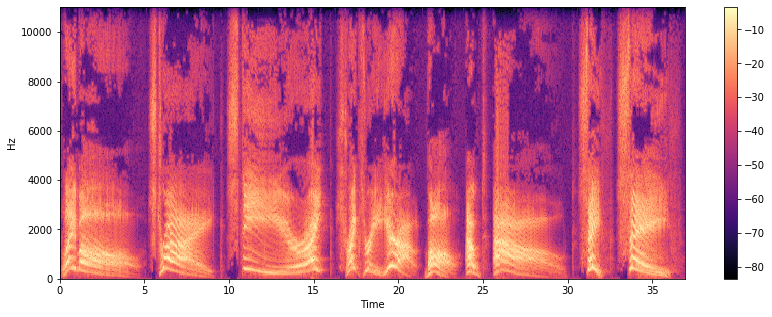

In [33]:
mellog_men = get_mel_log_spectogram(audata_men, n_fft=510, sr=sr_men)

#### Меняем shape спекторграммы, делим на части длинной L

In [34]:
L = load_json('./configs', 'audata_conf')['L']

In [39]:
old_spectogram_shape_digits, mellog_shaped_digits = get_new_spectogram_shape(mellog_digits, L)
print(f'Old shape: {old_spectogram_shape_digits}; New shape: {mellog_shaped_digits.shape}')

Old shape: (256, 1246); New shape: (5, 256, 256, 1)


In [40]:
old_spectogram_shape_men, mellog_shaped_men = get_new_spectogram_shape(mellog_men, L)
print(f'Old shape: {old_spectogram_shape_men}; New shape: {mellog_shaped_men.shape}')

Old shape: (256, 1589); New shape: (7, 256, 256, 1)


#### Save numpy arrays to file

In [41]:
np.save('samples/mellog_shaped_digits', mellog_shaped_digits)

In [42]:
np.save('samples/mellog_shaped_men', mellog_shaped_men)

#### Обучаем TraVeLGAN

In [21]:
train.train_model(mellog_shaped_digits, mellog_shaped_men,
                  hparams=load_json('./configs', 'audata_conf'), 
                  log='logging')

Launching experiment on device : cpu
Loading data..
Shape of dsA: (20, 128, 128, 1)
Shape of dsB: (26, 128, 128, 1)
Model loaded on device : cpu
Loading writer..
Start training..


KeyboardInterrupt: 

#### Получаем сгенерированную спектограмму

In [ ]:
generated_mellog_shaped_digits =

In [ ]:
generated_mellog_shaped_men =

#### Восстанавливаем старый shape спектограммы

In [384]:
generated_mellog_digits = get_old_spectogram_shape(generated_mellog_shaped_digits, old_spectogram_shape_digits)

In [385]:
generated_mellog_men = get_old_spectogram_shape(mellog_shaped_men, old_spectogram_shape_men)

#### Из Mel Log Spectrogram обратно в аудиодорожку

In [386]:
generated_audata_digits = get_audata_from_mel_log_spectogram(generated_mellog_digits)

In [387]:
generated_audata_men = get_audata_from_mel_log_spectogram(generated_mellog_men)

Транформированное аудио

In [389]:
Audio(generated_audata_digits, rate=sr_digits)

In [390]:
Audio(generated_audata_men, rate=sr_men)

Оригинальное аудио

In [360]:
Audio(audata_digits, rate=sr_digits)

In [361]:
Audio(audata_men, rate=sr_men)

## Free

In [229]:
import torch.nn as nn
import numpy as np
import torch

In [48]:
from torch.autograd import Variable

In [137]:
x = 3
x = Variable(torch.Tensor([x]), requires_grad=True)
# x.grad.zero_()

In [138]:
y = x ** 2
z = x ** 4

In [139]:
f = y + z

In [186]:
f.backward(retain_graph=True)

In [187]:
x.grad

tensor([342.])

In [181]:
x.grad.zero_()

tensor([0.])

In [188]:
x

tensor([3.], requires_grad=True)

In [189]:
x.data

tensor([3.])